In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOHCS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Potato_Train_Test_Data\Training_Data\PlantVillage",
    shuffle = True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 1 0 0 1 0 0 1 0 1 0 2 0 1 0 1 1 0 1 0 1 0 2 1 0 2 0 0 1]


(32, 256, 256, 3)
[0 1 1 1 1 0 2 1 0 0 2 1 1 1 0 0 0 0 1 2 2 1 0 0 1 0 0 0 0 2 0 0]


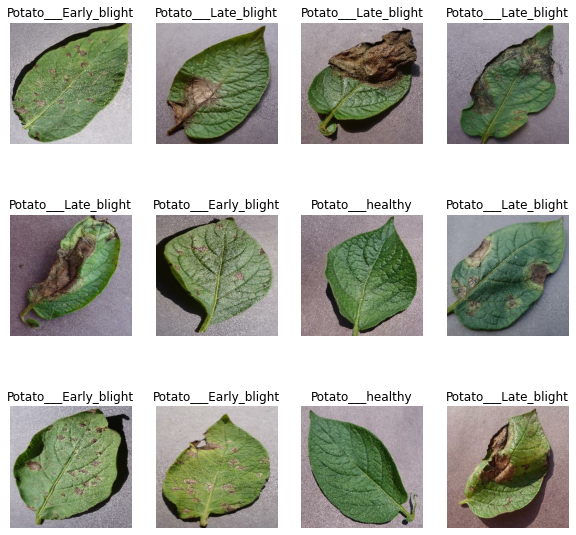

In [7]:
plt.figure(figsize  = (10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

Train_Test_Validation_Split

In [8]:
len(dataset)

68

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split= 0.8, val_split  =0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000):
    assert(train_split+val_split+test_split)==1
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

# Data Augmentation

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [20]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.654902   0.6313726  0.64705884]
  [0.654902   0.6313726  0.64705884]
  [0.6666667  0.6431373  0.65882355]
  ...
  [0.5568628  0.5137255  0.5058824 ]
  [0.5568628  0.5137255  0.5058824 ]
  [0.54509807 0.5019608  0.49411765]]

 [[0.6039216  0.5803922  0.59607846]
  [0.60784316 0.58431375 0.6       ]
  [0.6313726  0.60784316 0.62352943]
  ...
  [0.5372549  0.49411765 0.4862745 ]
  [0.5372549  0.49411765 0.4862745 ]
  [0.5294118  0.4862745  0.47843137]]

 [[0.60784316 0.58431375 0.6       ]
  [0.6        0.5764706  0.5921569 ]
  [0.60784316 0.58431375 0.6       ]
  ...
  [0.5254902  0.48235294 0.4745098 ]
  [0.5254902  0.48235294 0.4745098 ]
  [0.52156866 0.47843137 0.47058824]]

 ...

 [[0.8156863  0.7921569  0.8       ]
  [0.8        0.7764706  0.78431374]
  [0.8        0.7764706  0.78431374]
  ...
  [0.7176471  0.68235296 0.69411767]
  [0.7058824  0.67058825 0.68235296]
  [0.7019608  0.6666667  0.6784314 ]]

 [[0.8235294  0.8        0.80784315]
  [0.8117647  0.7882353  0.79607844]


# Normalisation

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)   
]
)

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Building CNN Model 

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape) 

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

# Compiling the Model

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 123s 2s/step - loss: 0.9127 - accuracy: 0.5023 - val_loss: 0.8890 - val_accuracy: 0.6510
Epoch 2/10
54/54 [==============================] - 104s 2s/step - loss: 0.6984 - accuracy: 0.7072 - val_loss: 0.5221 - val_accuracy: 0.7969
Epoch 3/10
54/54 [==============================] - 87s 2s/step - loss: 0.4665 - accuracy: 0.8056 - val_loss: 0.3360 - val_accuracy: 0.8698
Epoch 4/10
54/54 [==============================] - 87s 2s/step - loss: 0.3323 - accuracy: 0.8750 - val_loss: 0.2402 - val_accuracy: 0.9062
Epoch 5/10
54/54 [==============================] - 95s 2s/step - loss: 0.2178 - accuracy: 0.9167 - val_loss: 0.1696 - val_accuracy: 0.9167
Epoch 6/10
54/54 [==============================] - 99s 2s/step - loss: 0.1907 - accuracy: 0.9334 - val_loss: 0.1294 - val_accuracy: 0.9531
Epoch 7/10
54/54 [==============================] - 101s 2s/step - loss: 0.1683 - accuracy: 0.9317 - val_loss: 0.2613 - val_accuracy: 0.8906
Epoch 8/10
54/54 

In [27]:
len(test_ds)

8

In [28]:
score = model.evaluate(test_ds)

8/8 [==============================] - 4s 314ms/step - loss: 0.0912 - accuracy: 0.9609


In [29]:
score

[0.09115058183670044, 0.9609375]

In [30]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
history.history["loss"]

[0.9126547574996948,
 0.6983792185783386,
 0.46654078364372253,
 0.332285076379776,
 0.21779735386371613,
 0.19074386358261108,
 0.1683093011379242,
 0.13594010472297668,
 0.09343752264976501,
 0.10033821314573288]

In [33]:
history.history["accuracy"]

[0.5023148059844971,
 0.7071759104728699,
 0.8055555820465088,
 0.875,
 0.9166666865348816,
 0.9334490895271301,
 0.9317129850387573,
 0.9432870149612427,
 0.9670138955116272,
 0.9600694179534912]

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

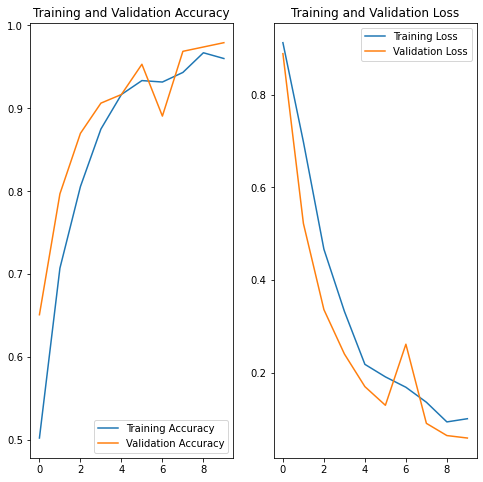

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 600ms/step
predicted label: Potato___Late_blight


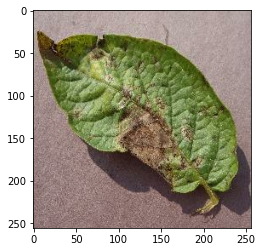

In [36]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[1])])    

# Write a function for inference

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


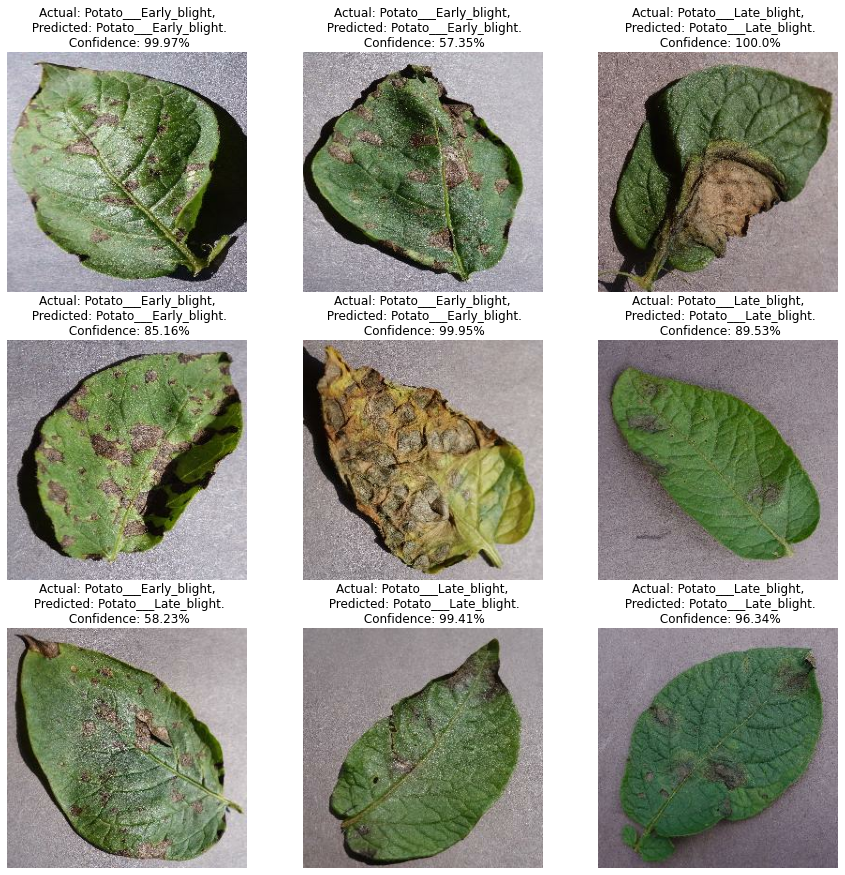

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model

In [45]:
model.save("D:\Potato_Train_Test_Data\Model")

INFO:tensorflow:Assets written to: D:\Potato_Train_Test_Data\Model\assets


INFO:tensorflow:Assets written to: D:\Potato_Train_Test_Data\Model\assets
